***РЕШЕНИЕ КОМАНДЫ Komarovo Enjoyers***


Для начала инсталлируем и импортируем нужные нам библиотеки

In [ ]:
!pip install timm
!pip install transformers
!pip install wandb
!pip install tqdm
!pip install lion-pytorch
!pip install datasets
!pip install evaluate
!pip install -U accelerate
!pip install optuna
!pip install git+https://github.com/openai/CLIP.git
!pip install pytorch-tabnet
!pip install gdown


In [27]:
import os
import sys
import re
import gc
import platform
import random
import matplotlib.pyplot as plt #графики
import plotly.express as px #графики
import seaborn as sns #графики


import numpy as np
import pandas as pd #пандас для загрузки датасета
from tqdm import tqdm # красивое отображение циклов

import torch #пайторч
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau


from datasets import Dataset # датасет для хаггингфейс
import pandas as pd
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoModel, BeitForImageClassification # нужно, чтобы качать модели с hf

from sklearn.metrics import roc_auc_score, f1_score # рассчитывать метрики
from sklearn.model_selection import StratifiedKFold, train_test_split
import evaluate  # рассчитывать метрики

import timm # библиотека с нужными моделями
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import glob
import cv2
from PIL import Image

import albumentations as A # аугментации
from albumentations.pytorch import ToTensorV2
from tqdm.contrib import tzip
import wandb

from transformers import XCLIPProcessor, XCLIPModel # трансформеры
from transformers import TrainingArguments, Trainer # обучение трансформеров
from sklearn.model_selection import KFold # кросс валидация
# from lion_pytorch import Lion # оптимайзер

from mpl_toolkits.axes_grid1 import ImageGrid # КРАСИВОЕ отображение фоток
from glob import glob

import clip
import warnings
warnings.simplefilter('ignore')

Установим сид, например мой любимый 69

In [4]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(69)

Скачиваем датасет (я залил на гдиск, для быстрой установки в колаб)

In [ ]:

!gdown --id "1OD8h6-24_dsROtS3oUKXlafitwS9-Kgr"
!gdown --id "1hGHENWO7mcLCozF9sQi97hjPTIN3JO0N"
!gdown --id "1o275BC_tXwFcZZ5NooC5EP90I13dSq8P"

In [11]:
import tarfile
tar = tarfile.open("/kaggle/working/train.tar.gz")
tar.extractall()
tar.close()

tar = tarfile.open("/kaggle/working/test.tar.gz")
tar.extractall()
tar.close()

Зарегаемся в вандб( облачные сервис), чтобы могли отслеживать подробно обучение

In [ ]:
wandb.login(key="36b8e8bc03f2d587e5aec94ad521bbd6e7c24774")
run = wandb.init(
    project='aiijc',
    config={k: v for k, v in CFG.__dict__.items() if not k.startswith('__')},
    job_type='train',
)

Загрузим датасет и посмотрим на него в общем

In [3]:
df = pd.read_csv('train_scores.csv')
df.head(5)

,IMAGE,SCORE
0,8fb58257ae6e79b8e953b5af9ab52ff3.jpg,3
1,cc08836eca604f11632824ac3495eea6.jpg,9
2,eaa01fcc9234d31775fac2dfb61a70a3.jpg,8
3,10fbe211548c292346c213ac94d3512c.jpg,8
4,bc1e32019d8e2d6ac3bbd6cf21fee395.jpg,8


Посмотрим на распределение скоров.
Можем заметить сильный дисбаланс в данных: крайне малое колво фоток со скором 2 и 10( со скором 1 вообще нету)

c:\Users\sigal\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\sigal\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SCORE', ylabel='Count'>

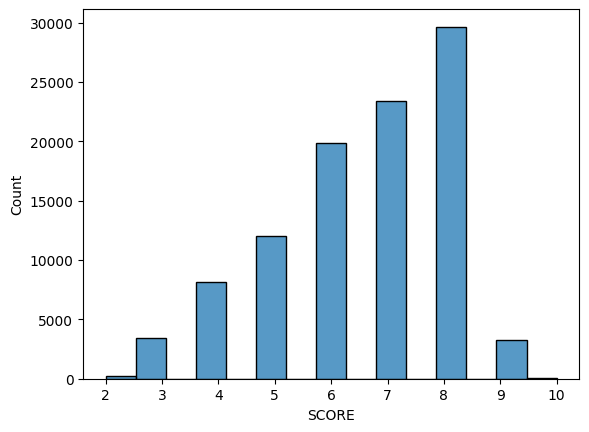

In [6]:
sns.histplot(data=df, x="SCORE", bins=15)

Логарифмическое распределение также не похоже на нормальное

In [122]:
fig = px.histogram(np.log1p(df.SCORE), color_discrete_sequence=[px.colors.qualitative.Pastel[5]],  text_auto=True)
fig.update_traces(marker_line_width=1, marker_line_color="white")
fig.update_layout(title="Количество фото каждого класса")
fig.update_layout(width=830, height=500)


Посмотрим на несколько фоток из датасета, можем предположить, что то что зависит на картинке не влияет на оценку пользователя(возможно опровергнем в будущем) - 1 гипотеза

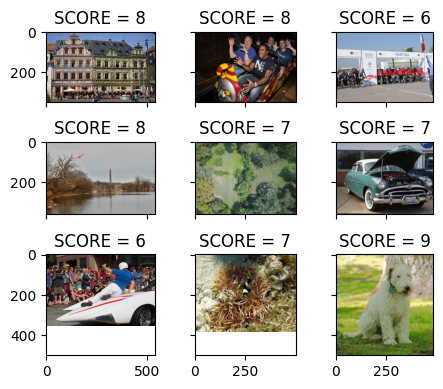

In [21]:
fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(3, 3),
                 axes_pad=0.4,
                 )

pathes = glob('train/*') #пути ко всем файлам в папке path to the all files
random_pathes = random.choices(pathes, k = 9)

images = [Image.open(img) for img in random_pathes] #выбираем 4 случайных фото и переводим их в RGB (OpenCV хранит фото в цветовом окружение BGR)
scores = [df[df.IMAGE == img_path.replace("train\\", "")]['SCORE'].astype(int).values[0] for img_path in random_pathes]
for ax, im in zip(grid, images):
    ax.set_title("SCORE = "+  str(scores[images.index(im)]), loc='center')
    ax.imshow(im)


plt.show()

**1) Сначала будем обучать датасет на моделям из huggingface, используя Trainer**

In [32]:
ds = Dataset.from_pandas(df)
ds = ds.class_encode_column("SCORE")
ds = ds.train_test_split(test_size=0.1, seed=42, shuffle=True, stratify_by_column='SCORE')
ds

Stringifying the column:   0%|          | 0/99910 [00:00<?, ? examples/s]

Casting to class labels: 100%|██████████| 99910/99910 [00:00<00:00, 601321.18 examples/s]


DatasetDict({
    train: Dataset({
        features: ['IMAGE', 'SCORE'],
        num_rows: 89919
    })
    test: Dataset({
        features: ['IMAGE', 'SCORE'],
        num_rows: 9991
    })
})

Возьмем для начала несколько моделей MolbileNetV2 и Beit

In [ ]:
preprocessor = AutoImageProcessor.from_pretrained("google/mobilenet_v2_1.4_224")
model = AutoModelForImageClassification.from_pretrained("google/mobilenet_v2_1.4_224", num_labels=10, ignore_mismatched_sizes=True)

In [ ]:
def auto_transforms(examples):
    images = [Image.open(path).convert("RGB") for path in examples["IMAGE"]]
    inputs = preprocessor(images=images, return_tensors="pt")
    inputs['labels'] = torch.tensor(examples['LABEL'])
    return inputs

In [ ]:
processor = AutoImageProcessor.from_pretrained("microsoft/beit-base-patch16-384")
model = AutoModelForImageClassification.from_pretrained("microsoft/beit-base-patch16-384", num_labels=10, ignore_mismatched_sizes=True)

In [ ]:
model = timm.create_model(CFG.model_name, pretrained=True, num_classes=11)
config = resolve_data_config({}, model=model)
processor = create_transform(**config)

Применим для нашего датасета трансформации нужные для каждой модели для обучения и загрузим рассчитывание метрик F1 и RMSE

In [ ]:
ds = ds.with_transform(auto_transforms)

In [ ]:
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator()

In [ ]:
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1.compute(predictions=predictions >= 8, references=labels>=8)

def custom_rmse(act, pred): # функция
    diff = pred - act # находим разницу между прогнозируемыми и наблюдаемыми значениями
    differences_squared = diff ** 2 # возводим в квадрат (чтобы избавиться от отрицательных значений)
    mean_diff = np.sqrt(differences_squared.mean()) # находим среднее значение

    return mean_diff

In [ ]:
training_args = TrainingArguments(
    output_dir="models/",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    weight_decay=1e-4,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    logging_steps=10,
    load_best_model_at_end=False,
    metric_for_best_model="f1",
    optim='adamw_torch',
    save_total_limit=1
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    tokenizer=preprocessor,
    compute_metrics=compute_metrics,
)

trainer.train()

Обучив каждую модель получили приемлимый, но не особо большой скор.
У MobileNetV2 был скор около 0.78-0.79, а у Beit 0.8 на f1

**2) Мы перешли к моделям из библиотеки timm, так как выбор там намного больше и более подходящий чем на hugginface**

In [ ]:
timm.list_models() # Посмотрим все модели из библиотеки timm, котоырые можем использовать

In [ ]:
class ImageDataset(Dataset): # Создадим датасет для использования в обучения
    def __init__(self, df, processor, split='train'):
        super().__init__()
        self.df = df
        self.split = split
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]

        image = np.array(Image.open(sample['IMAGE']))
        if self.split == 'train':
            image = Augments.train_augments(image=image)['image']
        else:
            image = Augments.valid_augments(image=image)['image']
        image = Image.fromarray(image)
        image = self.processor(image)
        label = torch.tensor(sample['LABEL']).long()
        return image, label

In [ ]:
class Augments: # Возьмем аугментации, которые возможно улучшат
    train_augments = A.Compose([
        # аугментации влияющие на цвет
        
        A.OneOf([
            A.CLAHE(p=1),
            A.ChannelShuffle(p=1),
            A.Equalize (p=1),
            A.RandomBrightnessContrast (p=1),
            A.ToGray(p=1),
        ], p=0.25),
        
        # аугментации влияющие на качество фото
        
        A.OneOf([
            A.Defocus(p=1),
            A.Downscale(scale_min=0.25, scale_max=0.75, interpolation=cv2.INTER_CUBIC,p=1),
            A.GaussianBlur (p=1),
            A.ISONoise (p=1),
            A.ImageCompression (p=1),
            A.Sharpen(p=1),
        ],p=0.25),
        
        # аугментации влияющие на размер фото
        
        A.OneOf([
            A.HorizontalFlip(p=1),
            A.VerticalFlip(p=1),
            A.RandomScale(scale_limit=(0, 1), p=1, interpolation=cv2.INTER_CUBIC),
            A.Rotate(limit=90, interpolation=cv2.INTER_CUBIC, p=1)
        ], p=0.5)
    ], p=1.)

    valid_augments = A.Compose([
    ], p=1.)

Поделим датасет на тренировочную выборку и валидационную, чтобы можно был оценивать результаты работ нашей моделей

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.1, random_state=42)

In [17]:
train_ds = ImageDataset(train_df, processor)
valid_ds = ImageDataset(valid_df, processor, 'test')

torch.Size([3, 384, 384])

Создадим класс для вычисления accuracy нашей модели и остальных метрик

In [18]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [19]:
def custom_f1(y_true, y_pred):
    return f1_score(y_true >= 8, y_pred >= 8)

def custom_rmse(act, pred): # функция
    diff = pred - act # находим разницу между прогнозируемыми и наблюдаемыми значениями
    differences_squared = diff ** 2 # возводим в квадрат (чтобы избавиться от отрицательных значений)
    mean_diff = np.sqrt(differences_squared.mean()) # находим среднее значение

    return mean_diff

Функции для тренировки и валидации нашей модели

In [25]:
def train_epoch(model, dataloader, optimizer, scheduler, loss_fn, epoch, device):
    model.train()
    running_loss = AverageMeter()
    prog_bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for batch, (images, targets) in prog_bar:
        optimizer.zero_grad()

        images = images.to(device, torch.float)
        targets = targets.to(device)

        preds = model(images)
        loss = loss_fn(preds, targets)

        loss.backward()
        optimizer.step()
        scheduler.step()

        loss_item = loss.item()
        running_loss.update(loss_item, images.size(0))

        prog_bar.set_description(f"loss: {running_loss.avg:.4f}")
    torch.cuda.empty_cache()
    return running_loss.avg

@torch.no_grad()
def valid_epoch(model, dataloader, loss_fn, epoch, device):
    model.eval()
    running_loss = AverageMeter()
    running_accuracy = AverageMeter()
    y_true = []
    y_pred = []
    prog_bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for batch, (images, targets) in prog_bar:
        images = images.to(device, torch.float)
        targets = targets.to(device)

        preds = model(images)
        loss = loss_fn(preds, targets)

        loss_item = loss.item()
        running_loss.update(loss_item, images.size(0))
        preds = preds.argmax(1).detach().cpu().numpy()
        targets = targets.detach().cpu().numpy()
        running_accuracy.update((targets == preds).sum() / images.size(0), images.size(0))
        y_pred.append(preds)
        y_true.append(targets)
        prog_bar.set_description(f"val_loss: {running_loss.avg:.4f}, val_acc: {running_accuracy.avg:.4f}")
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    torch.cuda.empty_cache()
    return running_loss.avg, custom_f1(y_true, y_pred), custom_rmse(y_true, y_pred)

Создадим даталоадеры, нужные для обучения нашей модели

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_loader = DataLoader(
        train_ds,
        batch_size=CFG.train_bs,
        shuffle=True,
        num_workers=CFG.num_workers
)

valid_loader = DataLoader(
        valid_ds,
        batch_size=CFG.valid_bs,
        shuffle=False,
        num_workers=CFG.num_workers
)

Создадим класс CFG с конфигом нашей модели и ее параметров, для удобства

In [ ]:
class CFG:
    epochs = 5 # кол-во эпох
    lr = 1e-4 # лернинг рейт
    model_name = 'beit_base_patch16_384' # модели
    train_bs = 16 # батч сайз
    valid_bs = 16 # батч сайз
    num_workers = 2 # кол-во "воркеров"
    eta_min = 1e-6 # параметр для оптимайзера
    wd = 1e-2 # weight decay

Для начала возьмем optimizer AdamW и шедулер CosineAnnealingLR, а лосс CrossEntrlopy и попрорбуем обучить модель

In [ ]:
model = model.to(device)
model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader) * CFG.epochs, eta_min=CFG.eta_min)
loss_fn = nn.CrossEntropyLoss()

Обучим модель

In [ ]:
current_acc = 0
for epoch in range(CFG.epochs):
    print(f"\n{'--'*8} EPOCH: {epoch+1} {'--'*8}\n")

    train_loss = train_epoch(model, train_loader, optimizer, scheduler, loss_fn, epoch=epoch, device=device)

    valid_loss, valid_acc, valid_f1 = valid_epoch(model, valid_loader, loss_fn, epoch=epoch, device=device)

    wandb.log({'Train/Loss': train_loss, 'Valid/Loss': valid_loss, 'Valid/Accuracy': valid_acc, 'Valid/F1': valid_f1})
    print('Train/Loss:', train_loss, 'Valid/Loss:', valid_loss, 'Valid/Accuracy:', valid_acc, 'Valid/F1:', valid_f1)

    current_acc = valid_acc
    torch.save(model.state_dict(), f"checkpoints/{CFG.model_name}_epoch_{epoch}.pt")

Обучив модель, получили скор f1=82.5, поняли, что можем лучше. После 3 эпохи модель начала переобучаться, соответственно выставим в конфиг 3 эпохи
Попробуем разработать пайплайн подбора оптимайзера и шедулера

In [34]:
class CFG:
    epochs = 3 # кол-во эпох
    lr = 1e-4 # лернинг рейт
    model_name = 'beit_base_patch16_384' # модели
    train_bs = 16 # батч сайз
    valid_bs = 16 # батч сайз
    num_workers = 2 # кол-во "воркеров"
    eta_min = 1e-6 # параметр для оптимайзера
    wd = 2e-5 # weight decay

In [ ]:
lion_opt = Lion(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd) # оптимайзер с гитхаба https://github.com/lucidrains/lion-pytorch
adam_optim = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd) # обычный АдамW

In [ ]:
reduce_scheduler = ReduceLROnPlateau(optimizer, 'min') # понижает лр, когда он перестает улучшатся
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader) * CFG.epochs, eta_min=CFG.eta_min) # связанный с косинусоидой
warm_scheduler = CosineAnnealingWarmRestarts(optimizer, T_mult=len(train_loader)) # также связжан с косинусоидой, но не имеет нижний границы

In [ ]:
import optuna # библиотека для тюнинга гиперпараметров
study = optuna.create_study(study_name="aiijc-optuna", direction="minimize")
study.optimize( _trials=5)

def suggest_hyperparameters(trial):

    scheduler = trial.suggest_categorical("scheduler_name": ['reduce_scheduler', 'cosine_scheduler', 'warm_scheduler'])

    optimizer_name = trial.suggest_categorical("optimizer_name", ["lion_opt", "adam_optim"])

    return scheduler, optimizer_name

Пайплайн подбоора гиперпараметров

In [ ]:
def objective(trial):
        scheduler, optimizer_name = suggest_hyperparameters(trial)

        # используем оптимайзер
        if optimizer_name == "adam_optim":
            optimizer = adam_optim
        elif optimizer_name == "lion":
            optimizer = lion_opt
        
        # используем шедулер
        if scheduler == 'reduce_scheduler':
            scheduler = reduce_scheduler
        elif scheduler == "cosine_scheduler":
            scheduler = cosine_scheduler
        elif scheduler == 'warm_scheduler':
             scheduler = warm_scheduler

        current_acc = 0
        for epoch in range(CFG.epochs):
            print(f"\n{'--'*8} EPOCH: {epoch+1} {'--'*8}\n")

            train_loss = train_epoch(model, train_loader, optimizer, scheduler, loss_fn, epoch=epoch, device=device)

            valid_loss, valid_acc, valid_f1 = valid_epoch(model, valid_loader, loss_fn, epoch=epoch, device=device)

            wandb.log({'Train/Loss': train_loss, 'Valid/Loss': valid_loss, 'Valid/Accuracy': valid_acc, 'Valid/F1': valid_f1})
            print('Train/Loss:', train_loss, 'Valid/Loss:', valid_loss, 'Valid/Accuracy:', valid_acc, 'Valid/F1:', valid_f1)

            current_acc = valid_acc
            torch.save(model.state_dict(), f"checkpoints/{CFG.model_name}_epoch_{epoch}.pt")

Получив все результаты, мы поняли, что лучший optimizer=AdamW, ведь Lion очень замедлял обучение и ухудшал скор
А лучший шедулер=CosineAnnealingLR, ведь он дает установимть нижнюю границу и соответственно, дает больше возможностей управлять обучением
Лучший скор на ф1 оказался 83.5 на модели BEit_base_384

***3) Использование CLIP для предсказания (креативный подход)***

Вдохновившись решением на недавнем соревновании "Дикая жизнь Уташуда" мы решили попробовать вытягивать эмбеддинги с каждой фотки и предсказывать по ним

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device) # модель клип

In [ ]:
def img_to_emb(img_paths:list): # функция вытягивания эмбеддингов из фотографии
    image_features=[]
    image_names=[]
    for img_path in tqdm(img_paths):
        img = np.array(Image.open(img_path))
        image = preprocess(Image.fromarray(img)).unsqueeze(0).to(device)

        with torch.no_grad():
            image_names.append(img_path)
            image_features.append(model.encode_image(image)[0].tolist())
    df=pd.DataFrame(np.array(image_features))
    df["IMAGE"] = image_names
    return df

После обработки мы получили такой датафрейм

In [39]:
embe = pd.read_csv("embeds.csv")
embe.head()

,0,1,2,3,4,5,6,7,8,9,...,504,505,506,507,508,509,510,511,IMAGE,LABEL
0,0.563477,0.084656,0.082886,0.262695,-0.076111,-0.392822,0.190918,0.864746,-0.327881,0.279297,...,-0.443848,0.088623,-0.175171,0.016281,-0.303223,0.372070,-0.145752,0.097900,/kaggle/working/train/562c2067186b1c3d83f877dd...,8
1,-0.310059,-0.061218,0.216431,0.432373,0.271729,0.016220,-0.208374,-0.142700,0.325195,-0.657715,...,-0.039673,-0.220825,0.135132,-0.195068,-0.046021,0.968262,0.058502,0.182739,/kaggle/working/train/9b61b90523ff096fa90cac22...,6
2,0.444580,-0.359375,0.111633,0.205566,0.678711,-0.309326,-0.265137,0.051666,-0.073181,0.223022,...,1.354492,0.021133,0.463623,-0.157715,0.105835,0.276855,-0.237915,0.386719,/kaggle/working/train/41b94c0e5816306617fc4849...,8
3,0.240601,-0.381836,-0.048798,0.317383,0.456543,-0.425293,0.399170,0.044586,0.222778,0.074036,...,0.078308,-0.133179,-0.291260,-0.366943,0.329346,0.495117,0.079224,-0.175537,/kaggle/working/train/9c84ac107cf9e1e9986f4852...,7
4,0.021103,-0.193726,0.127197,-0.275146,0.204346,0.023331,0.140869,0.819824,0.761230,0.247437,...,0.453857,-0.181641,-0.215454,0.206543,-0.449463,0.207642,-0.208374,-0.293213,/kaggle/working/train/915951c02f2e05250a63a808...,8


Для предикта по эмбеддингам, мы решили взять относительно новую модель TabNetClassifier, т.к она выдает лучшие результаты на похожих задачах в статьях в интернете

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

clf = TabNetClassifier(optimizer_fn=torch.optim.Adam)
clf.fit(X_train.values, Y_train.values, eval_set=[(X_test.values, Y_test.values)])

Но, к сожалению, мы получили скор около 0.5 на валидации и не стали развивать это решение(

***4) Улучшение обучения  моделей из тимм***

Мы решили взять несколько моделей, изменить их архитектуру и потом усреднить их результаты.
Из-за дисбаланса классов, мы решили взять FocalLoss, который добавляет вес малоресурсным классам

In [ ]:
class FocalLoss(nn.Module): 
    def __init__(self, gamma=2, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target):
        logpt = F.log_softmax(input, dim=1)
        pt = torch.exp(logpt)
        logpt = (1-pt)**self.gamma * logpt
        loss = F.nll_loss(logpt, target, self.weight)
        return loss

Для обучения мы решили взять модели Beit, Deit, Swin и все размера base, т.к. в ходе обучения разных моделей, мы поняли, что тяжелые быстро переобучаются

In [ ]:
timm.list_models()

In [ ]:
beit = timm.create_model("beit_base_patch16_384")
deit = timm.create_model("deit3_base_patch16_384")
swin = timm.create_model("swinv2_base_window16_256")

Также добавим AttentionBlock перед слоем классификации в каждую модель выше "https://blog.paperspace.com/image-classification-with-attention/" - статья про эти блоки

In [ ]:
class PoolBeit(timm.models.beit.Beit):
    def __init__(
            self,
            img_size = 224,
            patch_size = 16,
            in_chans: int = 3,
            num_classes: int = 1000,
            global_pool: str = 'avg',
            embed_dim: int = 768,
            depth: int = 12,
            num_heads: int = 12,
            qkv_bias: bool = True,
            mlp_ratio: float = 4.,
            swiglu_mlp: bool = False,
            scale_mlp: bool = False,
            drop_rate: float = 0.,
            pos_drop_rate: float = 0.,
            proj_drop_rate: float = 0.,
            attn_drop_rate: float = 0.,
            drop_path_rate: float = 0.,
            norm_layer = nn.LayerNorm,
            init_values = None,
            use_abs_pos_emb: bool = True,
            use_rel_pos_bias: bool = False,
            use_shared_rel_pos_bias: bool = False,
            head_init_scale: float = 0.001,
    ):
        super().__init__(img_size, 
                         patch_size, 
                         in_chans, 
                         num_classes,
                        global_pool,
                        embed_dim,
                        depth,
                        num_heads,
                        qkv_bias,
                        mlp_ratio,
                        swiglu_mlp,
                        scale_mlp,
                        drop_rate,
                        pos_drop_rate,
                        proj_drop_rate,
                        attn_drop_rate,
                        drop_path_rate,
                        norm_layer,
                        init_values,
                        use_abs_pos_emb,
                        use_rel_pos_bias,
                        use_shared_rel_pos_bias,
                        head_init_scale)
        self.pooling = AttentionBlock(embed_dim, embed_dim, 1)
    
    def forward_head(self, x, pre_logits: bool = False):
        if self.global_pool:
            x = self.pooling(x[:, self.num_prefix_tokens:])
        x = self.fc_norm(x)
        x = self.head_drop(x)
        return x if pre_logits else self.head(x)

Аналогично проведем такую же модели с Deit и Swin (не стал расписывать, оч много кода получится)

Также мы решили обучить каждую на кросс валидации (Stratified KFold), что также улучшило скор

In [ ]:
def fit(fold, train_ds, valid_ds):
    model = timm.create_model(CFG.model_name, pretrained=True, num_classes=11)
    config = resolve_data_config({}, model=model)
    processor = create_transform(**config)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_loader = DataLoader(
            train_ds,
            batch_size=CFG.train_bs,
            shuffle=True,
            num_workers=CFG.num_workers
    )

    valid_loader = DataLoader(
            valid_ds,
            batch_size=CFG.valid_bs,
            shuffle=False,
            num_workers=CFG.num_workers
    )

    model = model.to(device)
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader) * CFG.epochs, eta_min=CFG.eta_min)
    loss_fn = nn.FocalLoss()
    current_acc = 0
    for epoch in range(CFG.epochs):
        print(f"\n{'--'*8} EPOCH: {epoch+1} {'--'*8}\n")

        train_loss = train_epoch(model, train_loader, optimizer, scheduler, loss_fn, epoch=epoch, device=device)

        valid_loss, valid_acc, valid_f1, valid_rmse = valid_epoch(model, valid_loader, loss_fn, epoch=epoch, device=device)

        wandb.log({'Train/Loss': train_loss, 'Valid/Loss': valid_loss, 'Valid/Accuracy': valid_acc, 'Valid/F1': valid_f1, 'Valid/RMSE': valid_rmse})
        print('Train/Loss:', train_loss, 'Valid/Loss:', valid_loss, 'Valid/Accuracy:', valid_acc, 'Valid/F1:', valid_f1, "Valid/RMSE:", valid_rmse)

        current_acc = valid_acc
    torch.save(model.state_dict(), f"{CFG.model_name}_fold_{fold}.pt")

In [ ]:
skf = StratifiedKFold(n_splits=CFG.folds, random_state=42, shuffle=True) # используем ее а не KFold, т.к датасет на сбалансирован

for i, (train_index, test_index) in enumerate(skf.split(df[['IMAGE']], df['LABEL'])):
    train_df = df.loc[train_index].reset_index(drop=True)
    valid_df = df.loc[test_index].reset_index(drop=True)
    train_ds = ImageDataset(train_df, processor)
    valid_ds = ImageDataset(valid_df, processor, 'test')
    fit(i, train_ds, valid_ds)

Обучив каждую модель по фолдам, мы усреднили предикты каждого фолда каждой модели и получили 3 csv файла - предикты Beit, Deit и Swin
Получение предсказаний:

In [ ]:
class TestImageDataset(Dataset): # датасет дял паредикта теста
    def __init__(self, df, processor):
        super().__init__()
        self.df = df
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        sample = self.df.iloc[idx]
        image = np.array(Image.open('../aiijc/test/test/' + sample['IMAGE']).convert('RGB'))
        image = Augments.valid_augments(image=image)['image']
        image = Image.fromarray(image)
        image = self.processor(image)
        
        return image

In [ ]:
test_df = pd.read_csv('../sample_submission.csv')

test_ds = TestImageDataset(test_df, processor)
test_loader = DataLoader(
        test_ds,
        batch_size=CFG.valid_bs,
        shuffle=False,
        num_workers=CFG.num_workers
)

model.to('cuda')
predictions = None

for fold in range(CFG.folds): # усредняем предикты для каждого фолда каждой модели
    model.load_state_dict(torch.load(f"{CFG.model_name}_fold_{fold}.pt"))
    preds = inference(model, test_loader)
    if predictions is None:
        predictions = preds / CFG.folds
    else:
        predictions += preds / CFG.folds

Предикты получали последовательно для каждой модели

In [ ]:
@torch.no_grad()
def inference(model, dataloader): # получение предиктов
    model.eval()
    preds = []
    for images in tqdm(dataloader):
        images = images.to(device, torch.float)
        out = model(images)
        preds.append(out.detach().cpu().softmax(1).numpy())
    return np.concatenate(preds, axis=0)

Мы заметили, что на валидационных выборках у бейта был лучший скор, а у свина худший, соответсвенно мы усредняли результаты полученные по весам: Beit=0.5, Deit=0.3, Swin=0.2

In [ ]:
beit_probs = np.load('beit_fold_probs.npy')
deit_probs = np.load('deit3_fold_probs.npy')
swinv2_probs = np.load('swinv2_fold_probs.npy')

In [ ]:
test_df['SCORE'] = (beit_probs * 0.5 + deit_probs * 0.3 + swinv2_probs * 0.2).argmax(1)

На этом наше решение подошло к концу. В ходе решения этой интересной задачи, мы пытались придумывать новые, креативные решения, надеюсь наберем 10 баллов)